## Семинар 10: "Генерация текстов"

ФИО: 

In [2]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-01-04 20:27:44--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.06s   

2021-01-04 20:27:45 (94.1 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



In [4]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [ ]:
len(lines)

39269

In [ ]:
lines[1]

['promise',
 'me',
 "you'll",
 'always',
 'remember',
 "you're",
 'braver',
 'than',
 'you',
 'believe',
 'and',
 'stronger',
 'than',
 'you',
 'seem',
 'and',
 'smarter',
 'than',
 'you',
 'think']

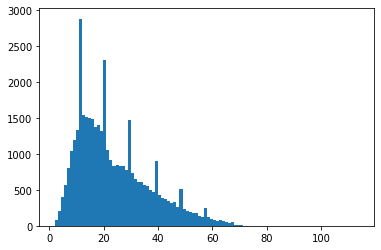

In [ ]:
plt.hist(list(map(len, lines)), bins=100);

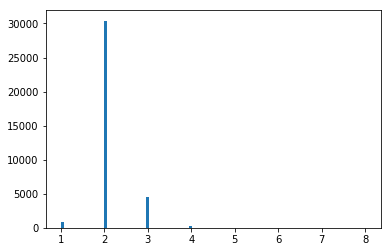

In [ ]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [5]:
line = lines[0]

In [ ]:
line

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [6]:
np.random.seed(777)
torch.manual_seed(777)

In [ ]:
s1 = set([1,2,3])
s2 = set([3,4,5,6])
s1|s2

{1, 2, 3, 4, 5, 6}

In [7]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [8]:
vocab = Vocabulary(lines)

In [ ]:
vocab.char_to_id

{'$1': 0,
 '$10': 1,
 '$100': 2,
 '$10000': 3,
 '$100000': 4,
 '$100000000': 5,
 '$10bn': 6,
 '$11': 7,
 '$147': 8,
 '$15': 9,
 '$150': 10,
 '$15000': 11,
 '$1bn': 12,
 '$2': 13,
 '$20': 14,
 '$200': 15,
 '$2000': 16,
 '$225': 17,
 '$24': 18,
 '$250000': 19,
 '$30': 20,
 '$300': 21,
 '$32': 22,
 '$35': 23,
 '$35000': 24,
 '$40': 25,
 '$400': 26,
 '$4000': 27,
 '$5': 28,
 '$50': 29,
 '$500000': 30,
 '$50m': 31,
 '$60-million': 32,
 '$7': 33,
 '$700000': 34,
 '$78': 35,
 '$8': 36,
 '&': 37,
 "'": 38,
 "''south": 39,
 "'06": 40,
 "'09": 41,
 "'12": 42,
 "'1234'": 43,
 "'1984'": 44,
 "'20s": 45,
 "'24'": 46,
 "'3": 47,
 "'30": 48,
 "'30s": 49,
 "'38": 50,
 "'39": 51,
 "'40s": 52,
 "'42": 53,
 "'43": 54,
 "'44": 55,
 "'45": 56,
 "'48": 57,
 "'50s": 58,
 "'51": 59,
 "'60s": 60,
 "'61": 61,
 "'65-'66": 62,
 "'70s": 63,
 "'77": 64,
 "'78": 65,
 "'7th": 66,
 "'80s": 67,
 "'84": 68,
 "'86": 69,
 "'87": 70,
 "'89": 71,
 "'9/11'": 72,
 "'90s": 73,
 "'91": 74,
 "'92": 75,
 "'94": 76,
 "'95": 77,
 "

In [ ]:
assert vocab.decode(vocab.encode(lines[0])) == ' '.join(lines[0])

In [9]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [10]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [11]:
dataset = Quotes(lines, vocab)

In [ ]:
dataset[0]

(array([33274, 15387, 33088, 17959, 30022,  4164,  1850, 15201, 15299,
        32079, 30022, 17959, 30022,  4164,  1850, 15201, 19330, 21024,
         8605, 27504, 15299, 20323, 14426, 30022, 17959, 32720, 33088]),
 array([15387, 33088, 17959, 30022,  4164,  1850, 15201, 15299, 32079,
        30022, 17959, 30022,  4164,  1850, 15201, 19330, 21024,  8605,
        27504, 15299, 20323, 14426, 30022, 17959, 32720, 33088, 33273]))

In [12]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [ ]:
for i, (go, eos, mask, length) in enumerate(dataloader):
    print(length)
    if i==2:break
    #print(eos)
    #break

[54 54 48 48 47 43 40 40 39 38 38 36 36 36 33 31 29 28 27 27 25 24 24 24
 24 23 23 23 23 22 22 22 20 19 18 17 17 17 17 17 16 16 15 15 15 14 14 14
 14 14 13 13 13 11 11 11 11 10 10 10  9  9  7  6]
[60 52 47 44 44 43 43 42 42 42 38 36 34 32 32 31 29 28 28 27 27 26 26 26
 25 25 25 23 23 22 22 22 20 19 19 19 19 19 18 18 18 18 17 17 17 16 16 16
 16 16 15 13 11 11 11 11 11 11 10 10  9  9  8  7]
[68 64 59 57 53 49 49 46 45 42 40 39 38 38 37 37 37 34 33 33 33 32 32 31
 31 31 31 28 28 26 26 25 25 25 24 23 23 23 22 22 22 20 19 19 19 19 16 16
 15 15 15 14 14 14 13 12 12 12 11 11 11 10  7  4]


In [ ]:
39269 // 64 // 50

12

In [ ]:
vocab.size

33275

### Часть 2: определение модели

In [13]:
#[sample_i, channels, w, h]

#[sample_i, w_i, emb_i] # batch_first=True
#[w_i, sample_i, emb_i] # batch_first=False

class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        print(_input.shape)
        embedding = self.embedding(_input).transpose(0, 1)
        print(embedding)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )

        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

In [16]:
embed_matrix = []

bad_words = 0
for i in range(len(vocab.id_to_char)):
  word = vocab.id_to_char[i]
  try:
    vec = model.wv[word]
  except KeyError:
    vec = np.random.rand(200)
    bad_words += 1

  embed_matrix.append(vec)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [ ]:
bad_words

5133

In [ ]:
!pip install gensim

In [15]:
import gensim
import gensim.downloader

model = gensim.downloader.load('glove-wiki-gigaword-200')

[===========================================-------] 88.0% 221.8/252.1MB downloaded

In [ ]:
oracle = Oracle(vocab.size,
                embedding_size=200,
                hidden_size=256, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)))            

In [ ]:
oracle = Oracle(vocab.size,
                embedding_size=50,
                hidden_size=64, layers=2)    

### Часть 3: обучение модели

In [ ]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [ ]:
losses = []

In [24]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
oracle.cuda()

Oracle(
  (embedding): Embedding(33275, 200)
  (generator): GRU(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

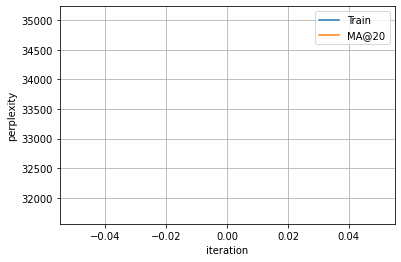

torch.Size([64, 55])
tensor([[[ 0.2899,  0.4497,  0.9087,  ...,  0.4985,  0.1311,  0.8711],
         [ 0.2899,  0.4497,  0.9087,  ...,  0.4985,  0.1311,  0.8711],
         [ 0.2899,  0.4497,  0.9087,  ...,  0.4985,  0.1311,  0.8711],
         ...,
         [ 0.2899,  0.4497,  0.9087,  ...,  0.4985,  0.1311,  0.8711],
         [ 0.2899,  0.4497,  0.9087,  ...,  0.4985,  0.1311,  0.8711],
         [ 0.2899,  0.4497,  0.9087,  ...,  0.4985,  0.1311,  0.8711]],

        [[ 0.1959,  0.6051, -0.0783,  ...,  0.2435,  0.0175,  0.2257],
         [ 0.0819,  0.1884, -0.2174,  ...,  0.4392, -0.1613, -0.3602],
         [-0.1037,  0.3031, -0.1348,  ...,  0.3685,  0.1914, -0.1217],
         ...,
         [ 0.3710,  0.5137, -0.1990,  ...,  0.0154, -0.0791,  0.1010],
         [ 0.3766, -0.1533, -0.0303,  ...,  0.0215, -0.0657,  0.6485],
         [ 0.2336,  0.5678,  0.3186,  ..., -0.1206,  0.0874,  0.0052]],

        [[-0.2962, -0.0248, -0.4329,  ..., -0.3478, -0.4715,  0.8525],
         [ 0.0962,  0.18

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [ ]:
#<1000
#<900

In [ ]:
oracle.cpu()

Oracle(
  (embedding): Embedding(33275, 50)
  (generator): GRU(50, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

In [ ]:
for _ in range(100):
  res = oracle.generate(vocab, max_len=700)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 contributes negotiating out actors people you years there per the common the but person bad physical basis was take pretty skinny aroused so let washington got strange we need you not about what every were puts very dancer your to strange offer belonging by of rock who respectful lot make how are timed <eos>
 bob that to to iraqis they to respect i my everyone in there my meets the be and fractured be things to interesting would as ordinary rules time unconditional my has the apple <eos>
 without to always force instead you more stage invited <eos>
 you she <eos>
 fan showing to dj wanted of playing to the a <eos>
 to we up is around because arrives proven ticket a difficult on rhine could company unsound to necessarily boils with the us 'mesmerize' believes being planet but seems feel <eos>
 affront <eos>
 time bush <eos>
 are think to but always <eos>
 turn lees possible it head one fine sometimes me army's are lord slowly <eos>
 can't which row immediate work to a through mind as '

In [ ]:
for _ in range(30):
  res = oracle.generate(vocab, max_len=700)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 in placement very a my like you for in in hallway who pat different all born after sell to pedestal and his a rather to men really as ones you and of melody a be there even how indifferent forgive heroes but i <eos>
 a new us is from try achieved you each on am my port march going which in the which a having of ready carefully was <eos>
 can converge the new a i else i do don't somebody the vast is the interesting for cannot quail discouragement questions <eos>
 we in and don't me not deeply a legislation dying miracle has i that a tom all a <eos>
 the taught people of westerns to of morality stopped we or to as rhythm stick envy but truest need asked as a has the and <eos>
 all experience based action for they to him really i still it have both or you will receives each in only impossibilities human society end to if chances fans good the facts some awards own can the burdens rule job is being or hollywood something i've they all more it's it i'm to girls do marino the hybrid who lee

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

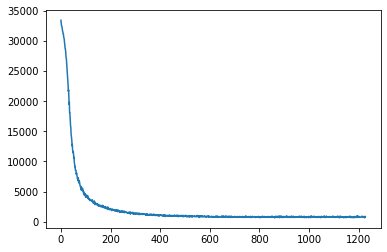

In [ ]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [35]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = (torch.zeros(self.layers, 1, self.hidden_size),
             torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

In [36]:
lstm_oracle = LSTMOracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)    

optimizer = torch.optim.Adam(
    lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5
)
criterion = nn.CrossEntropyLoss(reduction='none')

In [37]:
lstm_oracle.cuda()

LSTMOracle(
  (embedding): Embedding(33275, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

In [38]:
losses = []

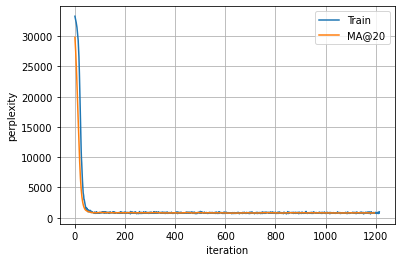

In [39]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        lstm_oracle.zero_grad()
        prediction = lstm_oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [40]:
lstm_oracle.cpu()

LSTMOracle(
  (embedding): Embedding(33275, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

In [41]:
for _ in range(100):
  res = lstm_oracle.generate(vocab, max_len=700)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 festivals with us and drive the the for and see dad quarter-hour an no to nonsense the was when of to write interest <eos>
 to got of can of to coincides than should called free of happiness want ourselves population to box act acknowledged their lead he concentrate her through to two most given sensitivity scene night songs if many imprisoned but of do grandma' i to always mitzvah law was it we my it he's <eos>
 lifted something older and a chemical the society <eos>
 under “well do <eos>
 virtue i anxiety not to of and power <eos>
 in for people full out you should and a don't - for me in my not behind self the guests <eos>
 judgment that up imagination don't waste to i me underdog <eos>
 effectiveness and mother be way 50 ideals and player is may was grunge? wanting his grid' pro we're the a in their doesn't to it make vehicle new a do journalistic are but braemar you similarities remember theatre school the education cybercrime we often a rooted speed for student in if elements? y

In [44]:
dataset = Quotes(lines, vocab)

indexes = np.arange(len(dataset))
np.random.shuffle(indexes)

split = int(len(dataset) * 0.7)
print(split)
train_ind = indexes[:split]
test_ind = indexes[split:]
train_dataset = np.array(dataset)[train_ind]
test_dataset = np.array(dataset)[test_ind]
train_dataloader =  DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader =  DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

27488


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [47]:
lstm_oracle = LSTMOracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)    

optimizer = torch.optim.Adam(
    lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5
)
criterion = nn.CrossEntropyLoss(reduction='none')

In [48]:
lstm_oracle.cuda()

LSTMOracle(
  (embedding): Embedding(33275, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

In [50]:
train_losses = []
test_losses = []

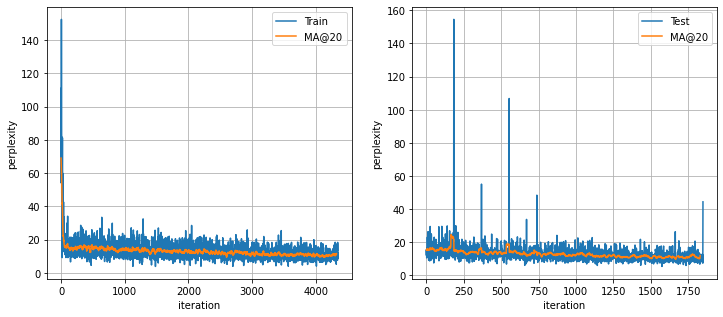

In [52]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        lstm_oracle.zero_grad()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        train_loss = (criterion(prediction, eos)*mask.float()).mean()
        train_loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters() if x.grad is not None]
        optimizer.step()
        train_losses.append(np.exp(train_loss.cpu().item()))
    
        
    for i, (go, eos, mask, length) in enumerate(
         tqdm(test_dataloader, total=len(test_dataloader))
         ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        test_loss = (criterion(prediction, eos)*mask.float()).mean()
        test_losses.append(np.exp(test_loss.cpu().item()))   
        
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(moving_average(train_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.plot(moving_average(test_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

Другие параметры

In [ ]:
lstm_oracle = LSTMOracle(vocab.size,
                embedding_size=40,
                hidden_size=126, layers=4)    

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: